In [1]:
import pandas as pd # for data wrangling and storage
import seaborn as sns # for visualizations
import matplotlib.pyplot as plt
import sqlite3 as sql # for connecting to a SQL server
cnn = sql.connect('nba.db')
cursor = cnn.cursor()
sns.set(rc = {'figure.figsize':(12,12)})

## Does free throw rate affect field goal percentage?

Let's use this new ability to use SQL to make some new observations that we couldn't earlier. It seems like intuition to say that if someone is better at drawing fouls and shooting free throws, then he would usually be better at making shots. Let's see if this is true

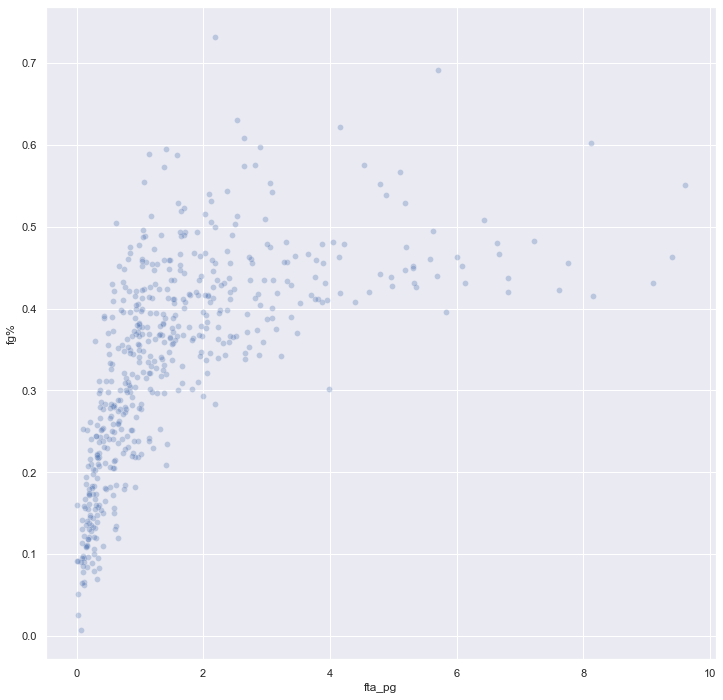

In [2]:
cursor.execute('''
SELECT player_name, AVG(fg_pct) fg_pct, AVG(fta) fta_pg, COUNT(*) num_games
FROM player
GROUP BY player_id
HAVING num_games > 41
ORDER BY fta_pg DESC ''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['name', 'fg%', 'fta_pg', 'games'])
sns.scatterplot(data=obs, x="fta_pg", y="fg%", alpha = 0.3)
plt.show()

In the above graph, it seems like there is a lot more to learn between this relationship. It does not seem like there is a lot to learn from this graph alone, but there is a clear relationship between free throw attempts per game and field goal percentage, as long as the percentage of free throws is between 0 and 4. It appears that the relationship may be less linear and more exponential. 

More potential and interesting research could be done to figure out how free throw rate affects total points. 

There definitely isn't enough here to come to any conclusions, but it does look like the results are as expected. 

## Do teams that shoot more 3-pointers win more games?

Recently in the NBA, a sort of 3-pointer revolution has occured, where the teams with great long distance shooting are also the teams that perform the best. Let's see if there is a strong correlation between   
1) The 3 point percentage of a team and winning  
2) The 3 point rate of a team and winning

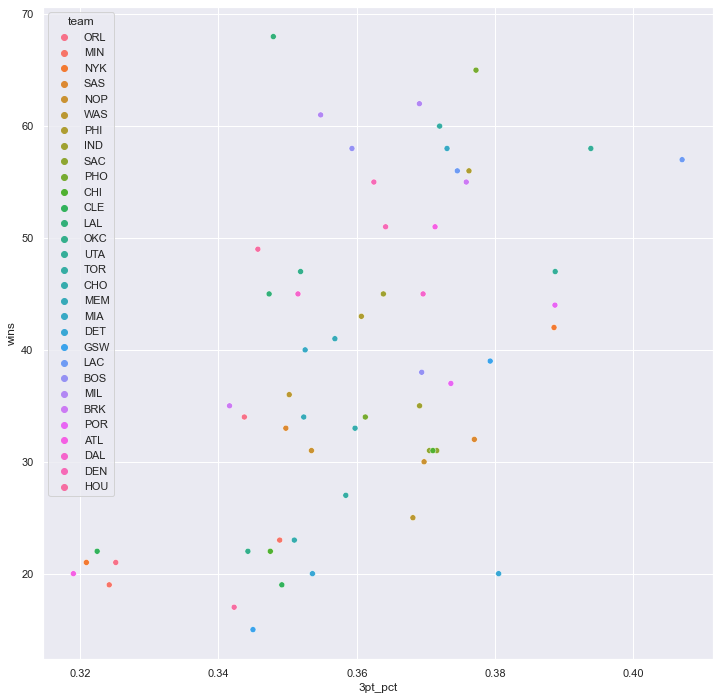

In [3]:
cursor.execute('''
select avg(win) wins, sum(fg3) fg3, sum(fg3a) fg3a, sum(fg) fg, sum(fga) fga, Team_Abbrev, season
From(select sum(fg3) fg3, sum(fg3a) fg3a, sum(fg) fg, sum(fga) fga, Team_Abbrev, season
FROM player NATURAL JOIN plays_for
GROUP BY player_id, season) NATURAL JOIN 
(select Team_Abbrev, season, sum(win) win
from Team
group by Team_Abbrev, season)
group by Team_Abbrev, season''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['wins', 'fg3', 'fg3a', 'fg', 'fga', 'team', 'season']).sort_values(by = 'fg3a')
obs['fg3a_per_fga_pct'] = obs.fg3a / obs.fga
obs['3pt_pct'] = obs.fg3 / obs.fg3a
obs = obs.drop(obs[obs.season == 2022].index) # remove the 2022 season since it isn't over yet
obs['team_season'] = obs['team'].map(str) + obs['season'].map(str)

# Plot the number of 3 pointers shot vs. the win%


sns.scatterplot(data = obs, x = '3pt_pct', y = 'wins', hue = 'team')
plt.show()

This plot is very unevenly distributed and, while there are some trends that point to 3-point percentage explaining the win percentage, we can dismiss this relationship as being linear.

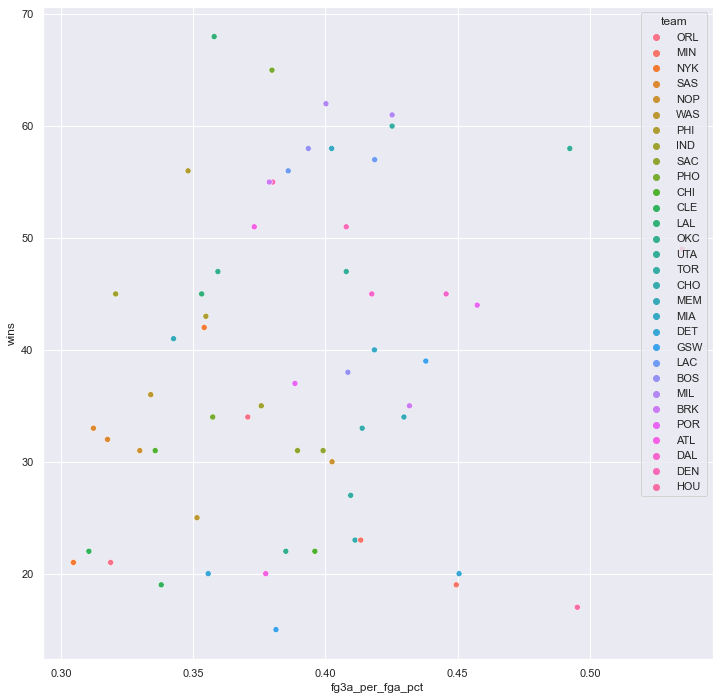

In [4]:
# Plot the 3point%  vs. the win%
sns.scatterplot(data = obs, x = 'fg3a_per_fga_pct', y = 'wins', hue = 'team')
plt.show()

This plot gives similar results to the last: there's very little covariation here, although there is some. Maybe if we were able to look at the covariation between both variables, we will see some slightly more normal results.

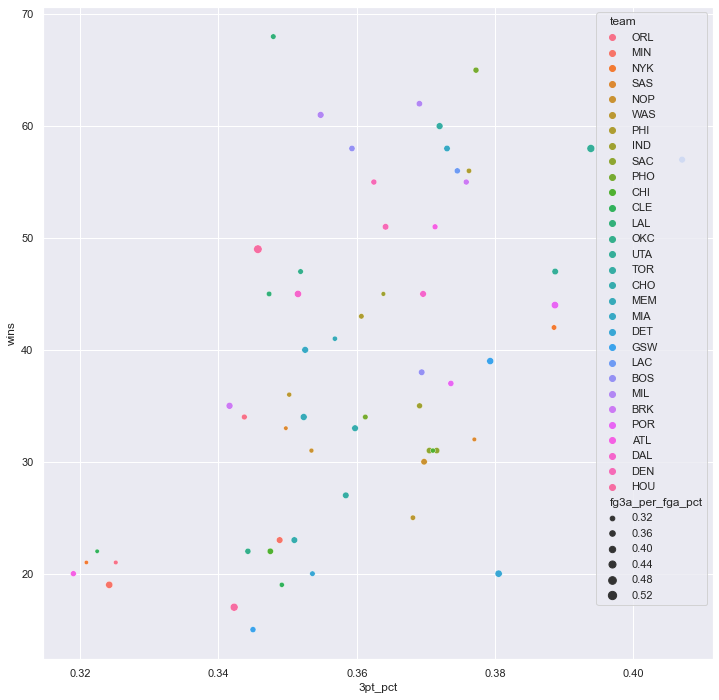

In [5]:
#combine
sns.scatterplot(data = obs, x = '3pt_pct', y = 'wins', size = 'fg3a_per_fga_pct', hue = 'team')
plt.show()

Unfortunately, it doesn't look like the covariation has any notable results either. We can dismiss this subject and move onto a new one.

## Does free throw percentage correspond to a high 3 point percentage?

This has been a commonly stated observation for a while: a high free throw percentage is usually a sign of a talented shooter. Let's see if this has any merit:

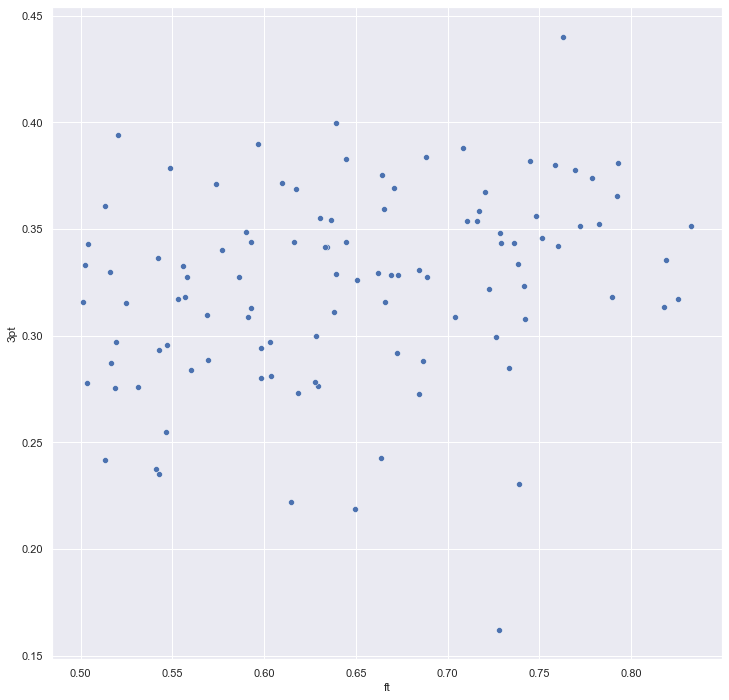

In [6]:
cursor.execute('''
SELECT player_name, avg(fg3_pct), avg(ft_pct)
FROM Player
GROUP BY player_id
HAVING COUNT(*) > 20 AND avg(ft_pct) > 0.5 AND sum(fg3a) > 200 ''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['name', '3pt', 'ft'])
sns.scatterplot(data = obs, x = 'ft', y = '3pt')
plt.show()

This, just like the graphs from the last question, is mostly non-linear. It's really strange that some players have such a bad free throw rate while having such a great 3-point rate (and vice-versa). 

## Do Teams that score more points win more games?

This seems like it should be obvious, but let's check and see if the relationship is as much of a no-brainer as it would seem. 

<AxesSubplot:xlabel='Average_Score', ylabel='wins'>

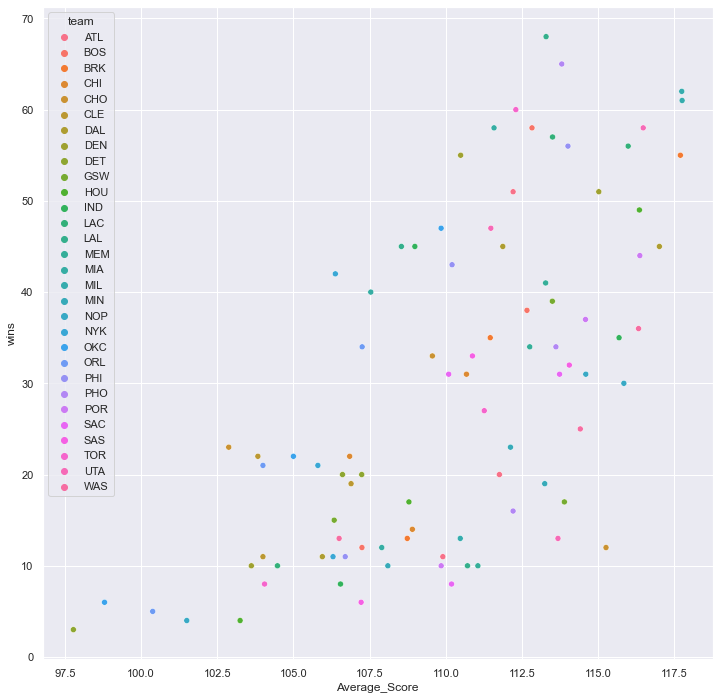

In [7]:
cursor.execute('''SELECT Team_Abbrev, Season, avg(Team_Score), sum(win)
FROM Team
GROUP BY Team_Abbrev, Season''')
obs = pd.DataFrame(cursor.fetchall(), columns = ['team', 'season', 'Average_Score', 'wins'])
sns.scatterplot(data = obs, x = 'Average_Score', y = 'wins', hue = 'team')

Finally - a somewhat linear relationship. Still, it seems like the most notable takeaway from this study is that nba data is very hard to draw linear relationships for. Because there are so many different factors involved, it would be very difficult to make a model of any relationship in NBA basketball. The graphs above tell that story very well. 

In [8]:
# Close the cursor and the connection

cursor.close()
cnn.close()